In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data_load import load_data, pmumu, nll, lam_i

data, flux = load_data()
dm2_approx = 0.002512121212121212
theta_approx = 0.677214566183642

For the choices of approximation, the values of dm2 using a fine range and then the values of theta, over a fine range, gathered from using the fine range dm2 value are used (dm2 --> dm2 fine (used) --> use dm2 value for theta --> theta fine (used)) just for consistency.

Just for clarity, the value of $\lambda_i$ is the expected counts in each energy bin:

$$
\lambda_i(\theta, \Delta m^2) = \Phi_i^{Unoscillated}P_{\mu\mu}(\theta_i, \Delta m^2)
$$

For parabolic minimsation we are using:

$$
f(x) = NLL(\theta_{fixed}, x), \text{where } x \equiv \Delta m^2
$$

And similarly for $\theta$ but keeping $\Delta m^2$ fixed, this is essentially a cost function.

We need three points say $x_0, x_1, x_2$ and then to evaluate $f(x_0) = y_0, f(x_1) = y_1, \text{and } f(x_2) = y_2$ (as from the notes)

We need to fit a quadratic (Lagrange Interpolating Polynomial) through these points :

$$
P_2(x) = \frac{(x-x_1)(x-x_2)}{(x_0-x_1)(x_0-x_2)}y_0 + \frac{(x-x_0)(x-x_2)}{(x_1-x_0)(x_1-x_2)}y_1 + \frac{(x-x_0)(x-x_1)}{(x_2-x_0)(x_2-x_1)}y_2
$$

We will then differentiate $P_2(x)$, setting the derivative to 0 and we can solve for x and rearrange to get:

$$
x_3 =\frac{1}{2} \frac{(x_2^2-x_1^2)y_0 + (x_0^2-x_2^2) y_1 + (x_1^2-x_0^2)y_2}{(x_2-x_1)y_0 +(x_0-x_2)y_1 + (x_1 - x_0)y_2}
$$

$x_3$ is our new estimate of the minimum, we then evaluate $y_3 = f(x_3)$ and loop, keeping the best three of $(x_0,y_0), (x_1, y_1) \text{ and } (x_2,y_2)$, repeat until $|x_3-x_1|$ < than a set tolerance, obviously replacing x with whatever value we're interested in ($\Delta m^2 \text{ or } \theta$)

For dm2 we got values ranging from $2.5-2.53 \times 10^{-3} eV^2$ and I will attempt to use a convergence criteria of $1\times 10^{-5}$ but if this takes too long then I may switch to $1\times 10^{-4}$ 

For theta we get a bit more change with values from 0.66 to 0.69 thus for now I will set the convergence criteria to $1\times 10^{-3}$

In [30]:
def parabolic(f, x0, x1, x2, tol, max_iter=300):
    """
    1D parabolic minimiser 

    f = NLL function for 1 var
    x0,x1,x2 = initial points
    tol = convergence critera

    Returns minimum of x and minimum of NLL at dm2_min
    """
    f0 = f(x0)
    f1 = f(x1)
    f2 = f(x2)

    x3_vals = []
    f3_vals = []

    # best so far
    x_best = x1
    f_best = f1

    # loop through iterations, break if denominator is too small/0, append trial vals for plotting
    for i in range(max_iter):
        denom = (x2 - x1) * f0 + (x0 - x2) * f1 + (x1 - x0) * f2
        if np.abs(denom) < 1e-14:
            break

        x3 = 0.5 * ((x2**2 - x1**2) * f0+ (x0**2 - x2**2) * f1+ (x1**2 - x0**2) * f2 ) / denom

        # keep x3 inside the current bracket to avoid wild jumps
        x_lo = np.min([x0, x1, x2])
        x_hi = np.max([x0, x1, x2])
        if (not np.isfinite(x3)) or (x3 <= x_lo) or (x3 >= x_hi):
            x3 = 0.5 * (x_lo + x_hi)

        f3 = f(x3)
        x3_vals.append(x3)
        f3_vals.append(f3)

        # update best value 
        if f3 < f_best:
            f_best = f3
            x_best = x3

        # convergence criteria check (stop when x3 stops moving)
        if len(x3_vals) > 1 and np.abs(x3_vals[-1] - x3_vals[-2]) < tol:
            break

        # store values
        x_all = np.array([x0, x1, x2, x3])
        f_all = np.array([f0, f1, f2, f3])

        # keep best 3 points by NLL, then sort by x so the bracket stays ordered
        keep = np.argsort(f_all)[:3]
        x_keep = x_all[keep]
        f_keep = f_all[keep]

        order = np.argsort(x_keep)
        x0, x1, x2 = x_keep[order]
        f0, f1, f2 = f_keep[order]

    # if no appends anything, return best of the initial three points
    if len(x3_vals) == 0:
        x_init = np.array([x0, x1, x2])
        f_init = np.array([f0, f1, f2])
        j = np.argmin(f_init)
        return x_init[j], f_init[j], np.array(x3_vals), np.array(f3_vals)

    return x_best, f_best, np.array(x3_vals), np.array(f3_vals)

# Test Function

In [32]:
def test(x):
    return (x+5)**2+3

min_test, f_min_test, test_vals, f_min_test_vals = parabolic(test, -20, 0, 20, tol = 1e-1)
print(min_test, f_min_test)
print(test_vals)

-5.0 3.0
[-5. -5.]


In [33]:
def nll_dm2(dm2):
    return nll(theta_approx, dm2)

def nll_theta(theta):
    return nll(theta, dm2_approx)

In [40]:
# choosing equally spaced starting points for dm2 initial guesses so that they bracket the min

dm2_0 = 1.4e-3
dm2_1 = 2.4e-3
dm2_2 = 3.4e-3

t0 = 0
t1 = 0.6
t2 = 1.2

dm2_min, nll_dm2_min, dm2_vals, nll_dm2_vals= parabolic(nll_dm2, dm2_0, dm2_1, dm2_2, tol = 1e-5)


theta_min, nll_theta_min, theta_vals, nll_theta_vals = parabolic(nll_theta, t0, t1, t2, tol = 1e-3)

In [41]:
print(f'{dm2_min}, {theta_min}')

0.002480905374061593, 0.6763937101490963


In [42]:
print(dm2_vals)
print(nll_dm2_vals)

print(theta_vals, nll_theta_vals)

[0.00244912 0.00264345 0.00248091 0.00244045 0.00246068 0.00246501]
[-74.37467064 -17.99655967 -83.95059138 -69.20164448 -79.34101788
 -80.72205835]
[0.72296581 0.70881861 0.67639371 0.69967976 0.69260616 0.68803673
 0.68449993 0.68221522 0.68044682 0.67930447 0.67842027] [-70.43961233 -77.12389731 -83.63606763 -80.22895885 -81.9554563
 -82.75182089 -83.19489815 -83.40034344 -83.51570953 -83.56994961
 -83.60098901]


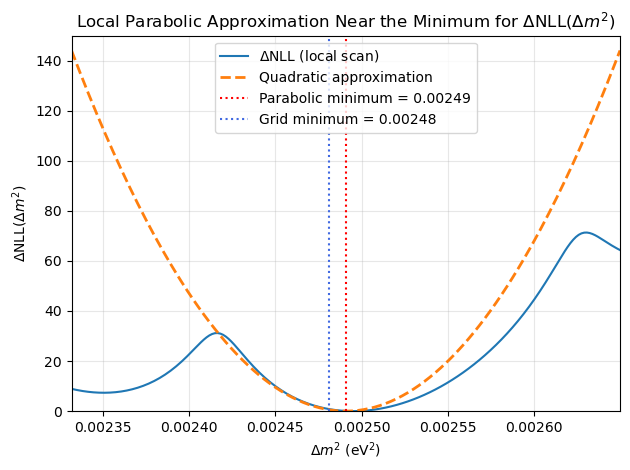

In [64]:
# best 3 points
x_fit = dm2_vals[np.argsort(nll_dm2_vals)[:3]]
y_fit = nll_dm2_vals[np.argsort(nll_dm2_vals)[:3]]

# Lagrange-based quadratic vertex
x0f, x1f, x2f = x_fit[np.argsort(x_fit)]
y0f, y1f, y2f = y_fit[np.argsort(x_fit)]


denom =(x0f-x1f)*(x0f-x2f)*(x1f-x2f)
if np.abs(denom)< 1e-20:
    print(':/')

A = (x2f*(y1f-y0f) + x1f*(y0f-y2f) + x0f*(y2f-y1f))/ denom
B = (x2f**2*(y0f-y1f) + x1f**2*(y2f-y0f) + x0f**2*(y1f-y2f))/denom
C = y0f - A*x0f**2 - B*x0f

# smooth curve around minimum
x_min = -B/(2*A)
dx = 10*np.abs(x_fit[1] - x_fit[0])
x_range = np.linspace(x_min - dx, x_min + dx, 200)
quad = A*x_range**2 + B*x_range + C

plt.plot(x_range, [nll_dm2(x) for x in x_range] - np.min([nll_dm2(x) for x in x_range]), label='$\Delta$NLL (local scan)')
plt.plot(x_range, quad - (C - B**2/(4*A)) , '--', linewidth=2, label='Quadratic approximation')
plt.axvline(x_min, linestyle=':', color='red', label=f'Parabolic minimum = {x_min:.5f}')
plt.axvline(dm2_min, linestyle=':', color='royalblue', label=f'Grid minimum = {dm2_min:.5f}')

plt.xlabel('$\Delta m^2$ (eV$^2$)')
plt.ylabel('$\Delta$NLL($\Delta m^2$)')
plt.title('Local Parabolic Approximation Near the Minimum for $\Delta$NLL($\Delta m^2$)')
plt.legend()
plt.xlim(x_range.min(), x_range.max())
plt.ylim(0, 150)
plt.grid(1, alpha=0.3)
plt.tight_layout()
plt.show()


In [65]:
print(abs(nll(x_min, theta_approx) - nll(dm2_min, theta_approx)))
print(abs(x_min - dm2_min))
print(x_min)

0.00013817348997235968
9.859043491009922e-06
0.002490764417552603


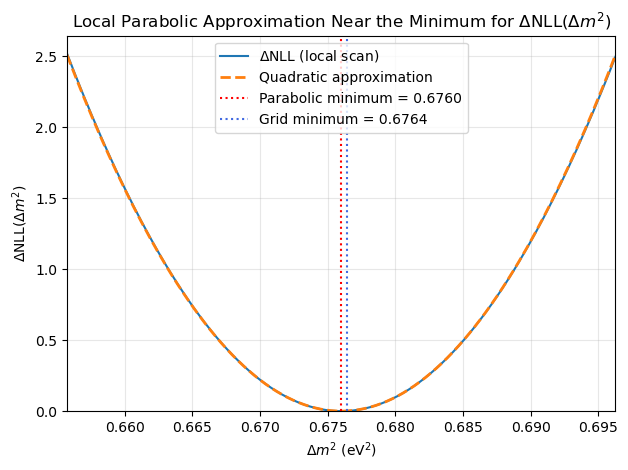

In [67]:
# best 3 points
x_fit = theta_vals[np.argsort(nll_theta_vals)[:3]]
y_fit = nll_theta_vals[np.argsort(nll_theta_vals)[:3]]

# Lagrange-based quadratic vertex
x0f, x1f, x2f = x_fit[np.argsort(x_fit)]
y0f, y1f, y2f = y_fit[np.argsort(x_fit)]


denom =(x0f-x1f)*(x0f-x2f)*(x1f-x2f)
if np.abs(denom)< 1e-20:
    print(':/')

A = (x2f*(y1f-y0f) + x1f*(y0f-y2f) + x0f*(y2f-y1f))/ denom
B = (x2f**2*(y0f-y1f) + x1f**2*(y2f-y0f) + x0f**2*(y1f-y2f))/denom
C = y0f - A*x0f**2 - B*x0f

# smooth curve around minimum
x_min = -B/(2*A)
dx = 10*np.abs(x_fit[1] - x_fit[0])
x_range = np.linspace(x_min - dx, x_min + dx, 200)
quad = A*x_range**2 + B*x_range + C

plt.plot(x_range, [nll_theta(x) for x in x_range] - np.min([nll_theta(x) for x in x_range]), label='$\Delta$NLL (local scan)')
plt.plot(x_range, quad - (C - B**2/(4*A)) , '--', linewidth=2, label='Quadratic approximation')
plt.axvline(x_min, linestyle=':', color='red', label=f'Parabolic minimum = {x_min:.4f}')
plt.axvline(theta_min, linestyle=':', color='royalblue', label=f'Grid minimum = {theta_min:.4f}')

plt.xlabel('$\Delta m^2$ (eV$^2$)')
plt.ylabel('$\Delta$NLL($\Delta m^2$)')
plt.title('Local Parabolic Approximation Near the Minimum for $\Delta$NLL($\Delta m^2$)')
plt.legend()
plt.xlim(x_range.min(), x_range.max())
plt.ylim(0)
plt.grid(1, alpha=0.3)
plt.tight_layout()
plt.show()

In [68]:
print(x_min)

0.6759913232677012
